在沙盒环境下，跳空技术分析

In [1]:
import os, copy, sys, itertools, pdb
os.environ['ULTRON_DATA'] = 'keim'
os.environ['IGNORE_WARNINGS'] = '1'
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

In [2]:
from ultron.ump.technical.jump import calc_jump, calc_jump_line,calc_jump_line_weight
from ultron.ump.technical.line import Line, K_PLT_MAP_STYLE

/var/log/ultron/2022-10-03.log


In [3]:
from ultron.env import *

In [4]:
enable_example_env()

2022-10-03 20:29:35,835 - [env.py:81] - ultron - INFO - enable example env will only read /home/kerry/ultron/rom/sandbox/keim


#### 加载行情

In [5]:
market_data = pd.read_csv(os.path.join(g_project_data, 'market_data.csv'), index_col=0)
market_data['trade_date'] = pd.to_datetime(market_data['trade_date'])

In [6]:
def next_returs_impl(price_data, key, name):
    price_tb = price_data[key].unstack()
    price_tb.fillna(method='pad', inplace=True)
    return_tb = np.log(price_tb.shift(-1) / price_tb)
    return_tb = return_tb.replace([np.inf, -np.inf], np.nan)
    return_tb = return_tb.stack().reindex(price_data.index)
    return_tb.name = name
    return return_tb

In [7]:
next_rets = next_returs_impl(
    market_data.set_index(['trade_date','code']),'closePrice','nxt1_ret').reset_index()
next_rets['trade_date'] = pd.to_datetime(next_rets['trade_date'])
next_rets.head()

,trade_date,code,nxt1_ret
0,2017-10-27,A,-0.0003
1,2017-10-27,AL,0.0012
2,2017-10-27,BU,0.0199
3,2017-10-27,C,-0.0054
4,2017-10-27,CF,0.0010


In [8]:
def pre_close_impl(price_data, key, name):
    price_tb = price_data[key].unstack()
    price_tb.fillna(method='pad', inplace=True)
    return_tb = price_tb.shift(-1)
    return_tb = return_tb.stack().reindex(price_data.index)
    return_tb.name = name
    return return_tb

In [9]:
pre_close = pre_close_impl(
    market_data.set_index(['trade_date','code']),'closePrice','pre_close').reset_index()
pre_close['trade_date'] = pd.to_datetime(pre_close['trade_date'])
pre_close.head()

,trade_date,code,pre_close
0,2017-10-27,A,4434.4424
1,2017-10-27,AL,15468.8167
2,2017-10-27,BU,3368.8829
3,2017-10-27,C,1991.7101
4,2017-10-27,CF,20469.6218


In [10]:
market_data = market_data.merge(next_rets, on=['trade_date','code']).merge(
    pre_close, on=['trade_date','code'])
market_data.head()

,trade_date,code,openPrice,highestPrice,lowestPrice,closePrice,turnoverVol,nxt1_ret,pre_close
0,2017-10-27,A,4462.5782,4463.8015,4413.6464,4435.6657,158774,-0.0003,4434.4424
1,2017-10-27,AL,15625.6586,15658.9047,15430.9315,15449.9293,293630,0.0012,15468.8167
2,2017-10-27,BU,3310.3399,3336.9504,3283.7295,3302.3568,461826,0.0199,3368.8829
3,2017-10-27,C,2009.7510,2014.5619,2001.3319,2002.5347,375480,-0.0054,1991.7101
4,2017-10-27,CF,20517.4960,20531.1743,20408.0694,20449.1043,84032,0.0010,20469.6218


In [11]:
market_data = market_data.set_index('code').loc['I']
market_data = market_data.rename(columns={
    'closePrice':'close','openPrice':'open',
    'highestPrice':'high','lowestPrice':'low',
    'turnoverVol':'volume','nxt1_ret':'p_change'})
market_data['p_change'] = market_data['p_change'] * 100
market_data['date'] = pd.to_datetime(market_data['trade_date']).dt.strftime('%Y%m%d').astype(int)
market_data = market_data.set_index('trade_date')
market_data.head()

,open,high,low,close,volume,p_change,pre_close,date
trade_date,,,,,,,,
2017-10-27,201.2739,201.9433,190.3400,191.0094,3088966,-0.7034,189.6705,20171027
2017-10-30,189.8937,193.2408,187.8854,189.6705,2271780,0.7034,191.0094,20171030
2017-10-31,189.6705,193.2408,188.1085,191.0094,2071056,0.3499,191.6788,20171031
2017-11-01,191.4557,195.9185,190.1168,191.6788,2236238,2.8688,197.2574,20171101
2017-11-02,191.2325,199.4888,190.1168,197.2574,2644964,-0.5672,196.1416,20171102


In [12]:
kl_pd = market_data[-252:]
kl_pd.head()

,open,high,low,close,volume,p_change,pre_close,date
trade_date,,,,,,,,
2021-06-08,982.3640,1011.3345,970.9514,1008.7008,407395,2.2376,1031.5261,20210608
2021-06-09,1013.9682,1046.0113,1009.5787,1031.5261,383946,0.2550,1034.1598,20210609
2021-06-10,1031.5261,1047.7671,1019.6745,1034.1598,345012,5.6923,1094.7345,20210610
2021-06-11,1038.9882,1095.6124,1038.9882,1094.7345,429828,-1.7392,1075.8598,20210611
2021-06-15,1094.7345,1094.7345,1040.3050,1075.8598,349292,-2.3113,1051.2787,20210615


##### 跳空统计分析

In [13]:
calc_jump(kl_pd, jump_diff_factor=1)

""


#### 跳空缺口筛选

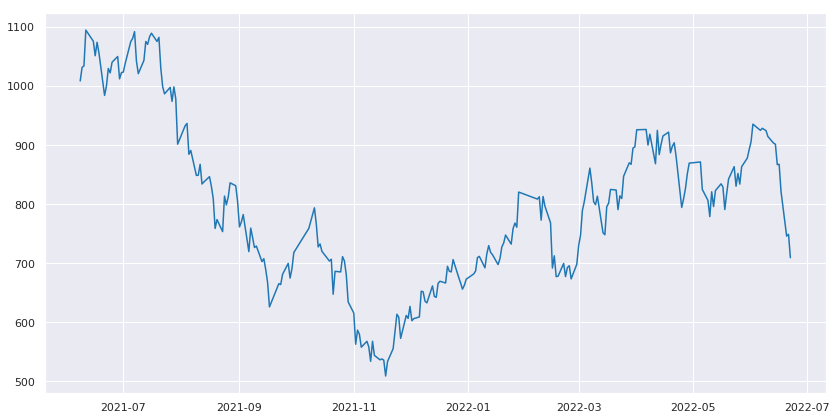

In [14]:
jump_lines = calc_jump_line(kl_pd, power_threshold=2.0,jump_diff_factor=1.0)
plt.figure(figsize=(14, 7))
plt.plot(kl_pd.close)
for jump_tuple, cs_color in zip(jump_lines,itertools.cycle(K_PLT_MAP_STYLE)):
    # 跳空点位对应的价格上面绘制横线，label标注跳空能量
    plt.axhline(jump_tuple.price,
                color=cs_color,
                label='power:' + str(jump_tuple.power))
    # 跳空描述：日期：up／down， 根据jump_tuple.direction跳空方向
    jump_desc = '{} : {}'.format(jump_tuple.date, ' up ' if jump_tuple.direction > 0 else ' down ')
    # 再把这个跳空时间点上画一个圆圈进行标示
    plt.plot(jump_tuple.date, jump_tuple.price,'ro',
             markersize=12,markeredgewidth=(1.0 * jump_tuple.power),
             markerfacecolor='None', markeredgecolor=cs_color,label=jump_desc)

    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.title('jump lines')

##### 缺口时间加权筛选

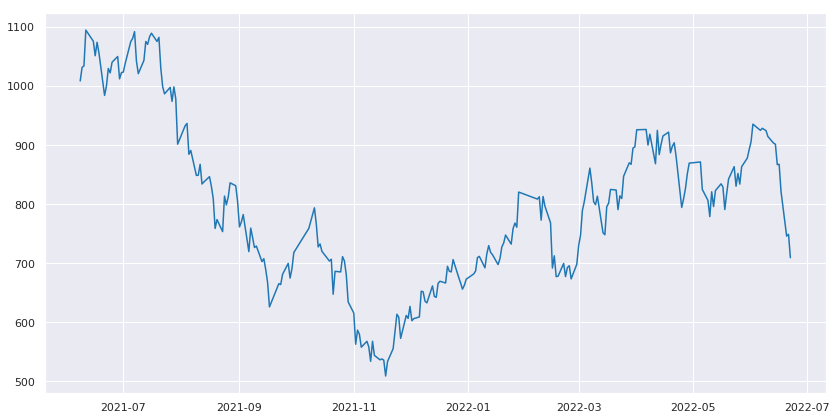

In [15]:
jump_lines = calc_jump_line_weight(kl_pd, sw=(0.3, 0.7), power_threshold=2.0,jump_diff_factor=1.0)
plt.figure(figsize=(14, 7))
plt.plot(kl_pd.close)
for jump_tuple, cs_color in zip(jump_lines,itertools.cycle(K_PLT_MAP_STYLE)):
    # 跳空点位对应的价格上面绘制横线，label标注跳空能量
    plt.axhline(jump_tuple.price,
                color=cs_color,
                label='power:' + str(jump_tuple.power))
    # 跳空描述：日期：up／down， 根据jump_tuple.direction跳空方向
    jump_desc = '{} : {}'.format(jump_tuple.date, ' up ' if jump_tuple.direction > 0 else ' down ')
    # 再把这个跳空时间点上画一个圆圈进行标示
    plt.plot(jump_tuple.date, jump_tuple.price,'ro',
             markersize=12,markeredgewidth=(1.0 * jump_tuple.power),
             markerfacecolor='None', markeredgecolor=cs_color,label=jump_desc)

    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.title('jump lines')